85 regions processed


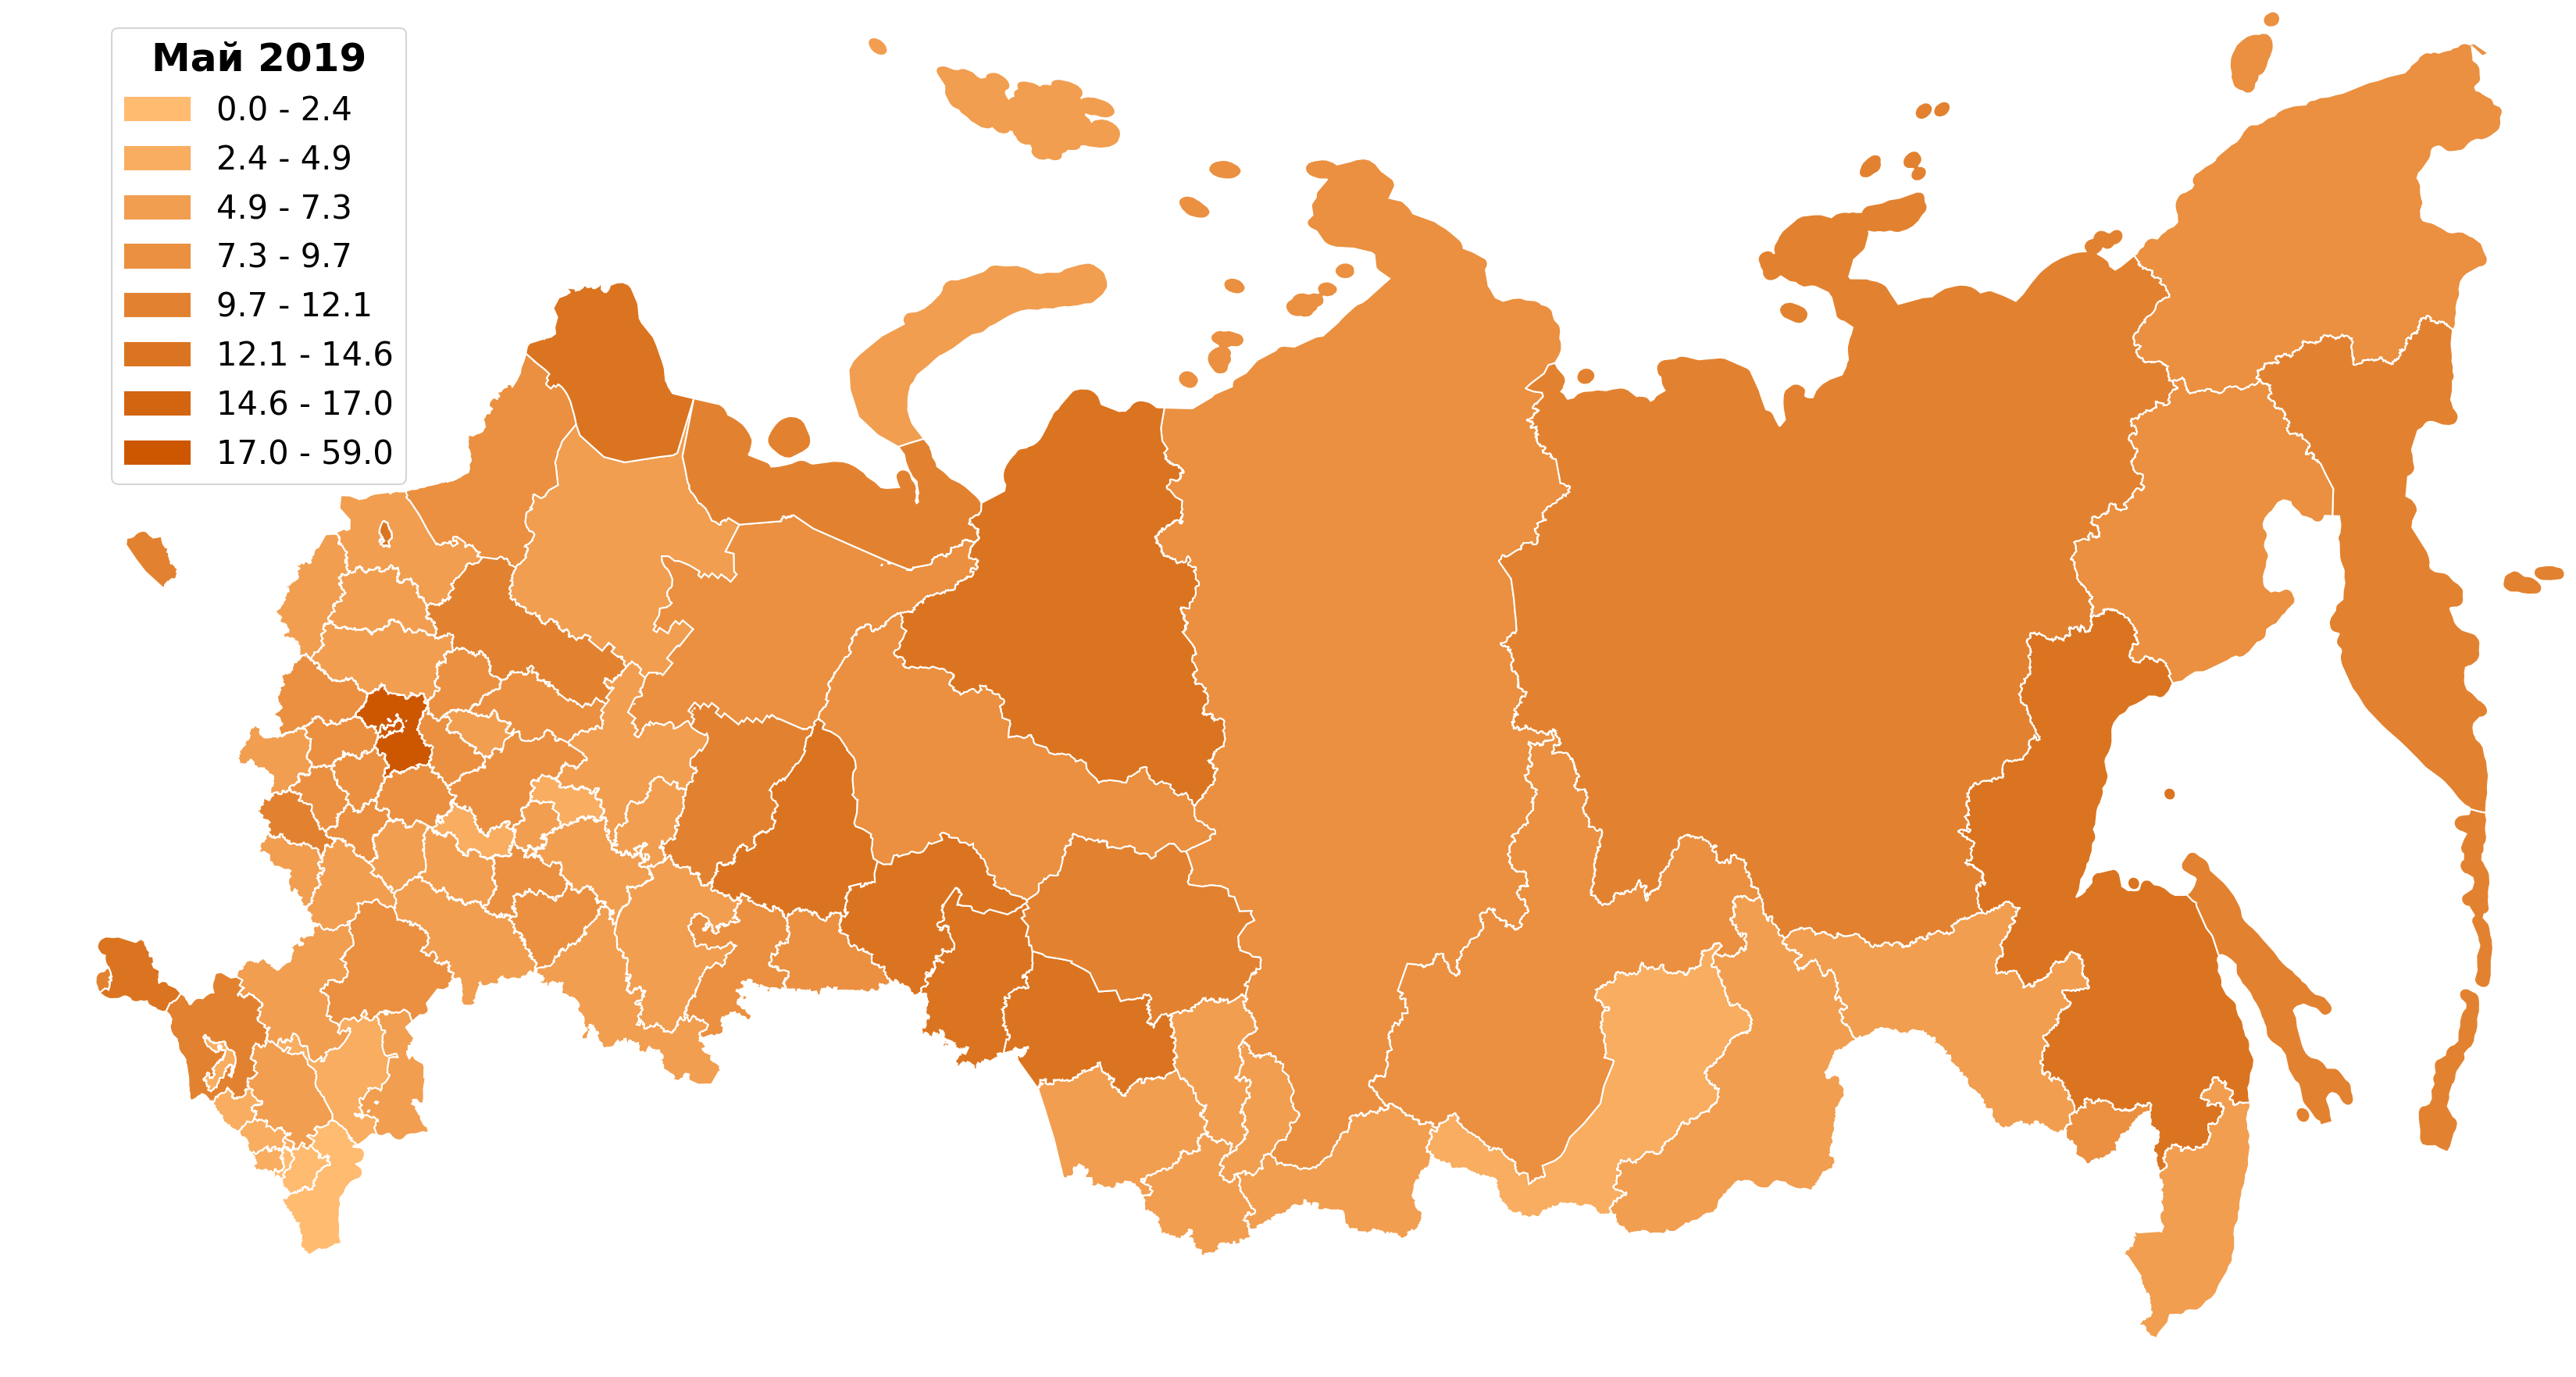

In [2]:
#!/usr/bin/env python3

import sys

import geojson
from descartes import PolygonPatch
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
from openpyxl import load_workbook


RENAME_DICT = {
    'Москва': 'г. Москва',
    'Санкт-Петербург': 'г. Санкт-Петербург',
    'Севастополь': 'г. Севастополь',
    'Кабардино-Балкария': 'Кабардино-Балкарская Республика',
    'Карачаево-Черкессия': 'Карачаево-Черкесская Республика',
    'Башкортостан': 'Республика Башкортостан',
    'Ингушетия': 'Республика Ингушетия',
    'Марий Эл': 'Республика Марий Эл',
    'Мордовия': 'Республика Мордовия',
    'Северная Осетия — Алания': 'Республика Северная Осетия - Алания',
    'Татарстан': 'Республика Татарстан',
    'Удмуртия': 'Удмуртская Республика',
    'Чувашия': 'Чувашская Республика',
    'Ханты-Мансийский автономный округ — Югра': 'Ханты-Мансийский автономный округ - Югра',
    'Карачаево-Черкесия': 'Карачаево-Черкесская Республика'
}


def load_regions_data(path):
    workbook = load_workbook(path)
    ws = workbook.worksheets[0]
    return dict(list(ws.values)[1:])


def main():
    data_path = './data.xlsx'
    regions_data = load_regions_data(data_path)

    with open("./russia_regions_preprocessed.geojson") as f:
        regions = geojson.load(f)


    c1=np.array(matplotlib.colors.to_rgb('#ffbb70'))
    c2=np.array(matplotlib.colors.to_rgb('#cd5700'))

    def get_color(val):
        return matplotlib.colors.to_hex((1 - val) * c1 + val * c2)
# TODO: Add automatic and logarithmic splitting of sets into segments
    n_colors = 8
    colors = [get_color(x) for x in np.linspace(0, 1, n_colors)]
    max_val = 17
    c_multiplier = (n_colors - 1) / max_val

    def choose_color(val):
        i = min(int(val * c_multiplier), len(colors) - 1)
        return colors[i]

    def plot_feature(feat, color, ax):
        poly = feat['geometry']
        ax.add_patch(PolygonPatch(poly, fc=color, ec='white'))

    fig = plt.figure(figsize=(30, 15), dpi=150)
    ax = fig.gca()
    cnt = 0
    for feat in regions['features']:
        reg_name = feat['properties']['localname']
        if reg_name in RENAME_DICT:
            reg_name = RENAME_DICT[reg_name]
        val = regions_data.get(reg_name)
        if val is None:
            continue
        plot_feature(feat, choose_color(val), ax)
        cnt += 1
    print('{} regions processed'.format(cnt))
    ax.margins(x=0, y=0)
    ax.axis('scaled')
    ax.axis('off')

# TODO: Mounth and last label fix
    legend_handlers = []
    for i, color in enumerate(colors[:-1]):
        legend_label = '{} - {}'.format(round(i / c_multiplier, 1), round((i + 1) / c_multiplier, 1))
        legend_handlers.append(mpatches.Patch(color=color, label=legend_label))
    legend_handlers.append(mpatches.Patch(color=colors[-1], label='{}.0 - 59.0'.format(max_val)))
    ax.legend(handles=legend_handlers, prop={'size': 20}).set_title('Май 2019', prop={"size": 24, 'weight': 'bold'})

    plt.savefig('map.png', transparent=True, bbox_inches='tight')


if __name__ == "__main__":
    main()